# Question 1

In this question we will:

- Implement a segmentation algorithm that uses random walker as the primary means to segment a noisy version of the leaf dataset from the previous assignment.
- Evaluate the performance of our algorithm in terms of mean Dice coefficient.
- Examine the best and worst results that we get from the dataset.
- Reason on why the algorithm works well on the 'best' cases and what causes it to fail on the 'worst' cases.



# Step 1: Write your Segmentation Algorithm

Write a function that segments a leaf image, and returns a binary (`dtype='bool'`) image representing the segmentation.  You may add additional parameters besides the image to be segmented if you wish.  Your algorithm must use the random-walker segmentation (``skimage.segmentation.random_walker()``) and you should consider doing some region processing after segmentation to improve the result.

Let's assume that, for the purposes of this, that de-noising the images would be too expensive because
our application has to run on a mobile device.   Thus, you are not allowed to denoise the images before applying the
random walker algorithm.

_Hint: The challenge here is to automatically find suitable foreground and background markers for the random walker algorithm.  The noisy images make for an additional challenge, but that's why we're using random walker; becuase of its robustness to noise._

_Hint: When you use `random_walker()` on a color image, make sure to set `channel_axis=2`._

_Hint: you may need to adjust the `beta` and `tol` arguments to the `ramdom_walker()` function to get excellent results._

_Hint: Output of the `random_walker()` function may be further post-processed using region processing methods._

In [31]:
import numpy as np
import skimage.util as util
import os as os
import skimage.io as io
import skimage.morphology as morph
import skimage.measure as measure
from skimage.segmentation import random_walker
import skimage.filters as filters

def segleaf(I):
    """
    Leaf segmentation using random walker
    :param I: Input image
    
    (Feel free to add as many addtional parameters as you
    want/need.)
    
    :return: 
    """

    I = util.img_as_float(I)
    R = I[..., 0]
    G = I[..., 1]
    B = I[..., 2]
    greenness = G - R - B


    thresh = np.percentile(greenness, 85)
    fg_seed = greenness > thresh
    bg_seed = greenness < (thresh - 0.1)

    markers = np.zeros(I.shape[:2], dtype=np.int32)
    markers[bg_seed] = 1
    markers[fg_seed] = 2


    labels = random_walker(
        I,
        markers,
        beta=0,
        tol=1e-3,
        channel_axis=2
    )

    mask = labels == 2

    mask = morph.remove_small_objects(mask, min_size=500)
    mask = morph.binary_closing(mask, morph.disk(5))
    mask = morph.remove_small_holes(mask, area_threshold=500)


    lab = measure.label(mask)
    props = measure.regionprops(lab)
    if len(props) > 0:
        largest = max(props, key=lambda r: r.area)
        mask = (lab == largest.label)

    return mask.astype(bool)


# Step 2: Write a Validation driver program.

Write code that segments each image, and computes the DSC for each segmentation.  Print the DSC of each segmentation as you perform it.  At the end, print the average of the DSC over all of the images. 

The general approach should be similar to Assignment 3.  For each input image (in the `noisyimages` directory):

* load the noisy image and it's ground truth
* segment the input image using the function you wrote in Step 1.
* Compute the DSC from the segmented image and the ground truth image (this function is given below).
* Print the DSC to the console.

When finished, print the average DSC for all images.  If you're getting a mean DSC of greater than 0.85, you're doing pretty good.

_Feel free to define additional helper functions for your program if you think it will help._

In [32]:
def dice_coefficient(bwA, bwG):
    '''
    Dice coefficient between two binary images
    :param bwA: a binary (dtype='bool') image
    :param bwG: a binary (dtype='bool') image
    :return: the Dice coefficient between them
    '''
    intersection = np.logical_and(bwA, bwG)

    return 2.0*np.sum(intersection) / (np.sum(bwA) + np.sum(bwG))


# Write your validation driver here.  It should be structured similarly to the driver in Assignment 3.  Again the image.csv file is provided with the names
# of all files to be processed.

images_path = os.path.join('/u1/cmpt487-819/data/asn3/', 'images')
gt_path = os.path.join('/u1/cmpt487-819/data/asn3/', 'groundtruth')
all_dsc = []
recognized_count = 0
total = 0

for root, dirs, files in os.walk(images_path):
    for filename in files:
        # ignore files that are not PNG files.
        if filename[-4:] != '.png':
            continue

        
        # concatenate variable root with filename to get the path to an input file.
        img_path = os.path.join(images_path, filename)
        gt_img_path = os.path.join(gt_path, filename)

        I = io.imread(img_path)
        GT = io.imread(gt_img_path) > 0 

        seg = segleaf(I)


        dsc = dice_coefficient(seg, GT)

        recognized = dsc > 0.6
        if recognized:
            recognized_count += 1

        all_dsc.append(dsc)
        total += 1

        print(f"Image: {filename}")
        print(f"  DSC = {dsc:.4f}  {'(recognized)' if recognized else ''}")
        print("--------------------------------------------------")

if total > 0:
    mean_dsc = np.mean(all_dsc)
    std_dsc = np.std(all_dsc)
    recognition_rate = 100.0 * recognized_count / total

    print("\n====== Validation Summary ======")
    print(f"Processed {total} images")
    print(f"Average DSC: {mean_dsc:.4f} ± {std_dsc:.4f}")
    print(f"Recognized leaves: {recognized_count}/{total} ({recognition_rate:.1f}%)")
    print("================================")
else:
    print("No images processed.")

Image: image_0078.png
  DSC = 0.9963  (recognized)
--------------------------------------------------
Image: image_0175.png
  DSC = 0.0000  
--------------------------------------------------
Image: image_0007.png
  DSC = 0.9945  (recognized)
--------------------------------------------------
Image: image_0160.png
  DSC = 0.9902  (recognized)
--------------------------------------------------
Image: image_0009.png
  DSC = 0.7027  (recognized)
--------------------------------------------------
Image: image_0165.png
  DSC = 0.9607  (recognized)
--------------------------------------------------
Image: image_0166.png
  DSC = 0.9708  (recognized)
--------------------------------------------------
Image: image_0090.png
  DSC = 0.9706  (recognized)
--------------------------------------------------
Image: image_0089.png
  DSC = 0.9787  (recognized)
--------------------------------------------------
Image: image_0104.png
  DSC = 0.9904  (recognized)
-------------------------------------------

# Step 3:  Display Examples

Choose one input image where your algoirthm performed very well.  Choose another image where the algorithm did not perform well.  Display the two original images with the segmentation superimposed on top (just like Step 4 in of assignment 3).  Also display the same two image's ground truth with the segmentation superimposed on top.    Title the images to indicate which is the "good" example, and which is the "bad" example.


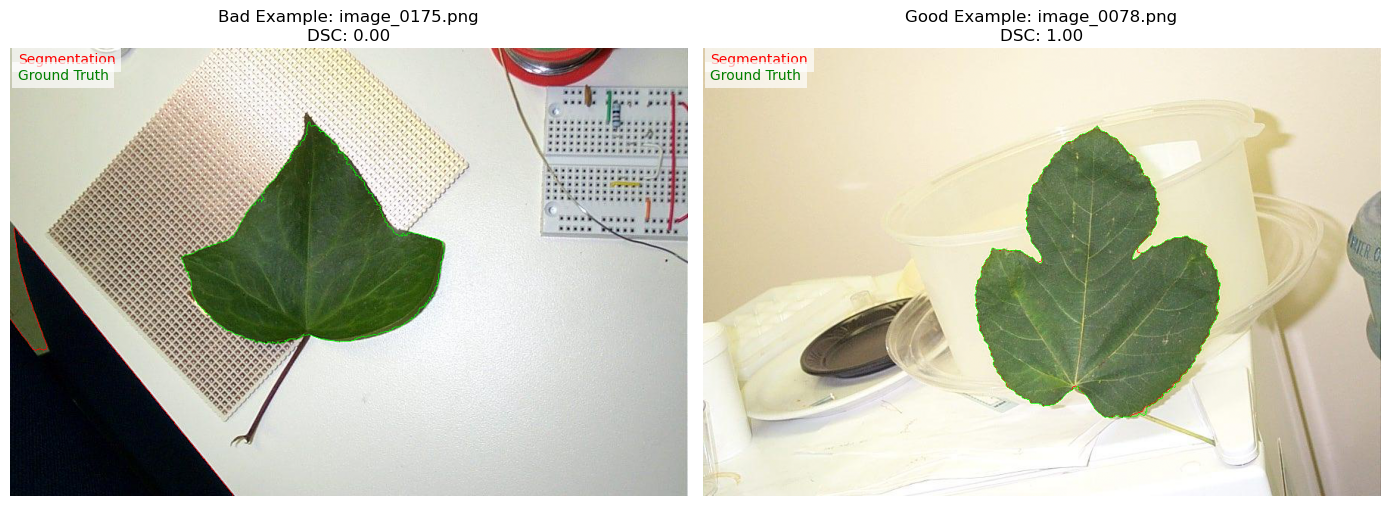

In [33]:
import matplotlib.pyplot as plt


import matplotlib.pyplot as plt
from skimage import io, segmentation, morphology as morph

%matplotlib inline

images_path = os.path.join('/u1/cmpt487-819/data/asn3/', 'images')
gt_path = os.path.join('/u1/cmpt487-819/data/asn3/', 'groundtruth')

good_img = "image_0078.png"
bad_img  = "image_0175.png"

I_good = io.imread(os.path.join(images_path, good_img))
GT_good = io.imread(os.path.join(gt_path, good_img)) > 0
seg_good = segleaf(I_good)

DSC_good = dice_coefficient(seg_good, GT_good)

I_bad = io.imread(os.path.join(images_path, bad_img))
GT_bad = io.imread(os.path.join(gt_path, bad_img)) > 0
seg_bad = segleaf(I_bad)

DSC_bad = dice_coefficient(seg_bad, GT_bad)


overlay_good = segmentation.mark_boundaries(I_good, seg_good, color=(1,0,0))
overlay_good = segmentation.mark_boundaries(overlay_good, GT_good, color=(0,1,0))
overlay_bad  = segmentation.mark_boundaries(I_bad, seg_bad, color=(1,0,0))
overlay_bad  = segmentation.mark_boundaries(overlay_bad, GT_bad, color=(0,1,0))


plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.imshow(overlay_bad)
plt.title(f"Bad Example: {bad_img}\nDSC: {DSC_bad:.2f}")
plt.axis("off")
# legend for colors
plt.text(10, 20, "Segmentation", color='red', fontsize=10, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
plt.text(10, 40, "Ground Truth", color='green', fontsize=10, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

plt.subplot(1,2,2)
plt.imshow(overlay_good)
plt.title(f"Good Example: {good_img}\nDSC: {DSC_good:.2f}")
plt.axis("off")
plt.text(10, 20, "Segmentation", color='red', fontsize=10, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
plt.text(10, 40, "Ground Truth", color='green', fontsize=10, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

plt.tight_layout()
plt.show()

# Step 4: Reflection

### Answer the following questions right here in this block.

1. In a few sentences, briefly explain what your segmentation algorithm from Step 1 does and how it works.  

	_Your answer:_  My algorithm uses the greeness index I created from the previous assignment (G - R - B) to create the labels for the image, where the foreground are any pixels that are considered in the 85th percentile of green (above greeness index), and the background are any pixels below the greeness index. I then use these labels with the random walker segmentation to segment the leaf in each image. I then also use functions from the morph library to remove segments that are less than 500 pixels, fill in holes from the main leaf segment, and fill in holes of false segments that are less than 500 pixels. 

2. Consider your good result.  What, if anything, about your algoirthm is preventing you from getting a better result with this image?  If you weren't able to get any results, leave this blank, or explain what was preventing you from getting a result.

	_Your answer:_  Overall my algorithm performed very well here. There is not much to improve, the only thing I could do is increase the accuracy of my algorithm by possibly changing the parameters for the random walker, like the beta and tol params, to slightly improve the result. 

3. Consider your bad result.  What is it about your algoirthm caused the poor performance on this image?   If you weren't able to get any results, leave this blank.

	_Your answer:_ ("The images are noisy" is not an acceptable answer.  Be more specific -- if noise is the problem, explain why your algorithm can't overcome the noise; what is preventing it, or what does it need to do better to succeed?)

For my bad image, it is very clear that my random walker was not able to segment anything, as the dsc i got was 0 here. I believe this is because by threshold was too high for my greeness, and therefore my algorithm could not segment anything sinec it considered the leaf as part of the background. This most likely happened in this image due to the object behind the leaf caused too much noise, making it too difficult to create a boundary around the leaf properly. I could probably improve this by modifying my theshold so that the leaf is properly segmented. 
